# Init

## Imports

In [376]:
import sys, os

import tensorflow as tf

import numpy as np

import requests

import matplotlib

# Specify the backend of matplotlib to display graphs (here tkinter backend)
matplotlib.use("TkAgg")

from matplotlib import pyplot as plt

# Used to display matplotlib inside jupyter notebook
%matplotlib inline


# Disable tensorflow update warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Declare Global Consts

In [377]:
API_KEY  = 'A0P959H21M0HZXUB'
LOOKBACK = 24
PREDICT  = 10

# Create dataset

## Fetch data

In [378]:
def fetch_data(stock):
    r = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={stock}&apikey={API_KEY}&datatype=csv')
    return r.text.split('\r\n')

dataset = fetch_data('GOLD')

In [379]:
def format_data(dataset):
    tab = []
    for line in dataset:
        tab.append(line.split(','))
    for line in tab[1:]:
        for i in range(len(line)):
            if i == 0:
                line[i] = len(tab) - tab.index(line) - 1
            line[i] = float(line[i])    
    labels = tab[0]
    tab = list(reversed(tab[1:]))
    tab = tab[1:] # Remove last line which is empty
    return labels, tab    

labels, dataset = format_data(dataset)

## Visualize dataset

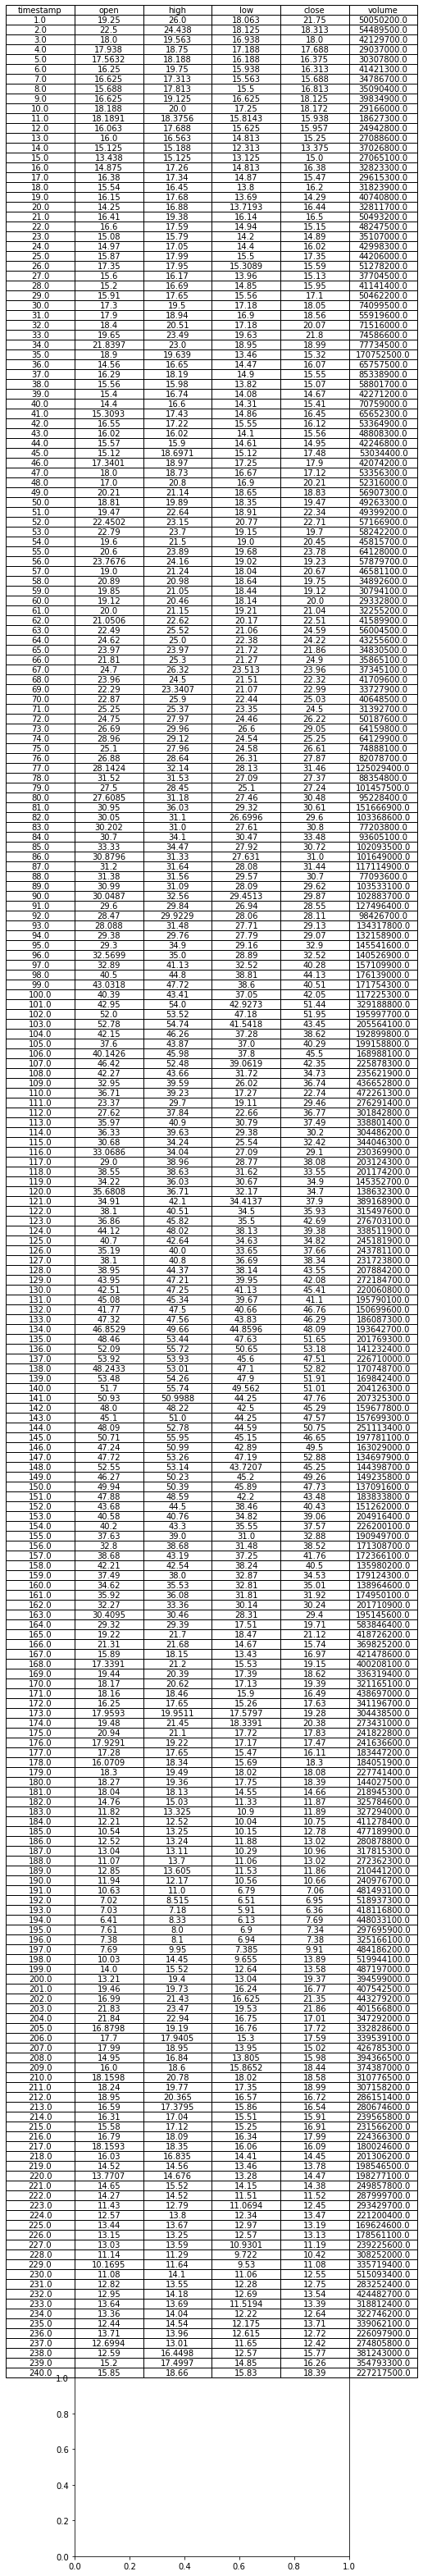

In [380]:
def visualize_data(labels, dataset):
    plt.table(cellText=dataset,
          colWidths = [0.25]*len(dataset[0]),
          colLabels=labels,
          cellLoc = 'center', rowLoc = 'center',
          loc='top')

visualize_data(labels, dataset)

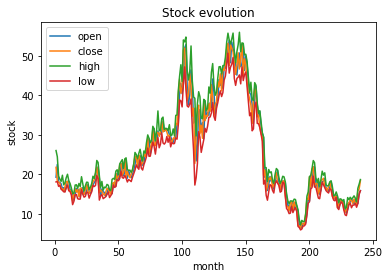

In [381]:
def plot_data(dataset):
    data_open = [data[1] for data in dataset]
    data_high = [data[2] for data in dataset]
    data_low = [data[3] for data in dataset]
    data_close = [data[4] for data in dataset]
    data_time = [data[0] for data in dataset]
    plt.plot(data_time , data_open)
    plt.plot(data_time , data_close)
    plt.plot(data_time , data_high)
    plt.plot(data_time , data_low)
    plt.title('Stock evolution')
    plt.ylabel('stock')
    plt.xlabel('month')
    plt.legend(['open', 'close', 'high', 'low'], loc='upper left')
    plt.show()

plot_data(dataset)

## Normalize data

In [382]:
def normalize_data(dataset):
    dataset = np.swapaxes(dataset,0,1)[1:]
    for i in range(len(dataset)):
        dataset[i] = (dataset[i] - min(dataset[i])) / (max(dataset[i]) - min(dataset[i]))
    dataset = np.swapaxes(dataset, 0, 1)
    return dataset

dataset = normalize_data(dataset)
print(dataset)

[[0.27025889 0.38589297 0.27163612 0.32870568 0.05559419]
 [0.33866554 0.35386508 0.2730219  0.25529688 0.06344832]
 [0.24394864 0.25390609 0.24649084 0.2486117  0.04158104]
 ...
 [0.13007788 0.19007177 0.14886008 0.20098249 0.64154891]
 [0.18501368 0.21159934 0.19982119 0.2114481  0.59475343]
 [0.19869501 0.23539061 0.22172553 0.25694148 0.36904308]]


## Split dataset

In [383]:
def split_dataset(dataset):
    x, y = [], []
    for i in range(LOOKBACK, len(dataset)):
        x.append(dataset[i-LOOKBACK:i])
        y.append(dataset[i])
    return np.array(x), np.array(y)

x_train, y_train = split_dataset(dataset)

x_test = x_train[int(len(x_train) - PREDICT):]
x_train = x_train[:int(len(x_train) - PREDICT)]

y_test = y_train[int(len(y_train) - PREDICT):]
y_train = y_train[:int(len(y_train) - PREDICT)]

print("Train\t", x_train.shape, '\t', y_train.shape)
print("Test\t", x_test.shape, '\t', y_test.shape)

Train	 (206, 24, 5) 	 (206, 5)
Test	 (10, 24, 5) 	 (10, 5)


# AI

## Define model

In [384]:
def define_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(len(x_train), input_shape=(LOOKBACK, 5), return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(5, activation='relu'))
    return model

model = define_model()

## Compile model

In [385]:
def compile_model(model):
    model.compile(optimizer='adam',loss='mse')
    model.summary()
    return model

model = compile_model(model)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 206)               174688    
_________________________________________________________________
dropout_43 (Dropout)         (None, 206)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 1035      
Total params: 175,723
Trainable params: 175,723
Non-trainable params: 0
_________________________________________________________________


## Train AI

In [386]:
def train_ai(model, x_train, y_train):
    history = model.fit(x_train, y_train, epochs=150, batch_size=27, validation_split=0.2)
    return history, model
    
history, model = train_ai(model, x_train, y_train)

Train on 164 samples, validate on 42 samples
Epoch 1/150
164/164 [==============================] - 1s 9ms/sample - loss: 0.1835 - val_loss: 0.0417
Epoch 2/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.1097 - val_loss: 0.0443
Epoch 3/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0814 - val_loss: 0.0252
Epoch 4/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0694 - val_loss: 0.0206
Epoch 5/150
164/164 [==============================] - 0s 2ms/sample - loss: 0.0256 - val_loss: 0.0271
Epoch 6/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0187 - val_loss: 0.0178
Epoch 7/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0154 - val_loss: 0.0138
Epoch 8/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0142 - val_loss: 0.0122
Epoch 9/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0129 - val_loss: 0.0115
Epoch 10/150
164/164 [======

164/164 [==============================] - 0s 1ms/sample - loss: 0.0067 - val_loss: 0.0077
Epoch 80/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0063 - val_loss: 0.0075
Epoch 81/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0070 - val_loss: 0.0075
Epoch 82/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0065 - val_loss: 0.0069
Epoch 83/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0064 - val_loss: 0.0077
Epoch 84/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0065 - val_loss: 0.0072
Epoch 85/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0078 - val_loss: 0.0077
Epoch 86/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 87/150
164/164 [==============================] - 0s 1ms/sample - loss: 0.0071 - val_loss: 0.0069
Epoch 88/150
164/164 [==============================] - 0s 1ms/sample - loss:

## Visualize training

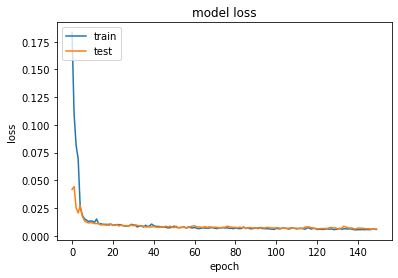

In [387]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_loss(history)

## Test model

In [402]:
def test_model(model, x_test, y_test):
    output = model.predict(np.array([x_test]))
    error = []
    for i in range(len(output)):
        error.append(abs(100 - output[i] * 100 / y_test[i]))
    error = np.array(error)
    return np.mean(error)

errors_means = []
for i in range(PREDICT):
    errors_means.append(test_model(model, x_test[i], y_test[i]))
for mean in errors_means:
    print('#' + str(errors_means.index(mean)), "Average error", mean, "%")
print("\nAVERAGE ERROR", np.mean(np.array(errors_means)), "% (calculated on the", PREDICT, "last months of the dataset)")

#0 Average error 108.53499 %
#1 Average error 65.312195 %
#2 Average error 65.39442 %
#3 Average error 62.482643 %
#4 Average error 85.10632 %
#5 Average error 55.498547 %
#6 Average error 72.49595 %
#7 Average error 63.329857 %
#8 Average error 54.563793 %
#9 Average error 44.22729 %

AVERAGE ERROR 67.694595 % (calculated on the 10 last months of the dataset)
